In [7]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import soundfile as sf

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
# Defining the paths to the clean audio and noise audio folders
clean_audio_folder = 'test data/clean'
noise_audio_folder = 'test data/noise'

In [268]:
clean_audio_files = glob(os.path.join(clean_audio_folder, '*.wav'))
noise_audio_files = glob(os.path.join(noise_audio_folder, '*.wav'))

In [269]:
def play_audio(y):
    return ipd.Audio(y)
# Playing audio file

play_audio(clean_audio_files[0])

In [270]:
y, sr = librosa.load(clean_audio_files[0])
print(f'y: {y[:10]}')
print(f'shape y: {y.shape}')
print(f'sr: {sr}')

y: [-0.00253091 -0.00386398 -0.00366104 -0.00350641 -0.00385854 -0.00383131
 -0.0036565  -0.00374619 -0.00378876 -0.00376538]
shape y: (77497,)
sr: 22050


In [120]:
def plot_waveform(y, title):
    pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title=title,
                 color=color_pal[0])
plt.show()

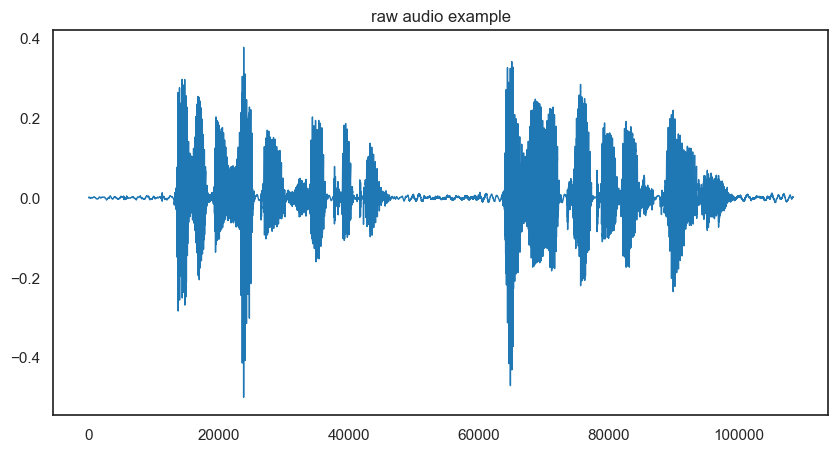

In [160]:
plot_waveform(y, 'raw audio example')

In [271]:
y_trimmed, _ = librosa.effects.trim(y, top_db=20)

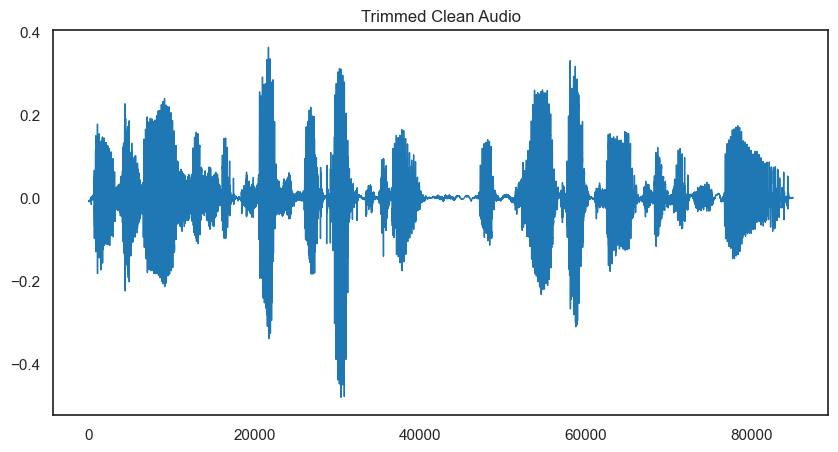

In [123]:
plot_waveform(y_trimmed, 'Trimmed Clean Audio')

In [15]:
def extract(signal, frame_size=512, hop_length=256):
        stft = librosa.stft(signal,
                                n_fft=frame_size,
                                hop_length=hop_length)
        spectrogram = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(spectrogram)
        return log_spectrogram

In [272]:
spec= extract(y_trimmed)

In [21]:
def plot_spect(y, title):
    # Plot the spectogram
    fig, ax = plt.subplots(figsize=(10, 5))
    img = librosa.display.specshow(y,
                                x_axis='time',
                                y_axis='log',
                                ax=ax)
    ax.set_title(title, fontsize=20)
    fig.colorbar(img, ax=ax, format=f'%0.2f')
    plt.show()

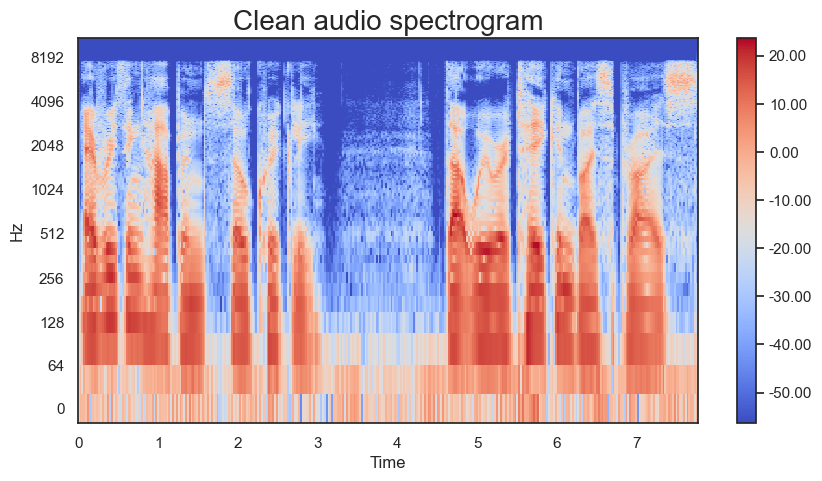

In [163]:
plot_spect(spec, 'Clean audio spectrogram')

In [273]:
play_audio(noise_audio_files[0])

In [274]:
y_noise, noise_sr = librosa.load(noise_audio_files[0])
print(f'y: {y_noise[:10]}')
print(f'shape y: {y_noise.shape}')
print(f'noise_sr: {noise_sr}')
y_noise_trimmed, _ = librosa.effects.trim(y_noise, top_db=20)

y: [ 1.1402108e-06 -5.5211814e-07 -7.3171304e-07  1.5902617e-06
 -1.1000527e-06 -6.3201315e-07  2.2994391e-06 -2.1949518e-06
 -5.0778294e-07  4.9548330e-06]
shape y: (832021,)
noise_sr: 22050


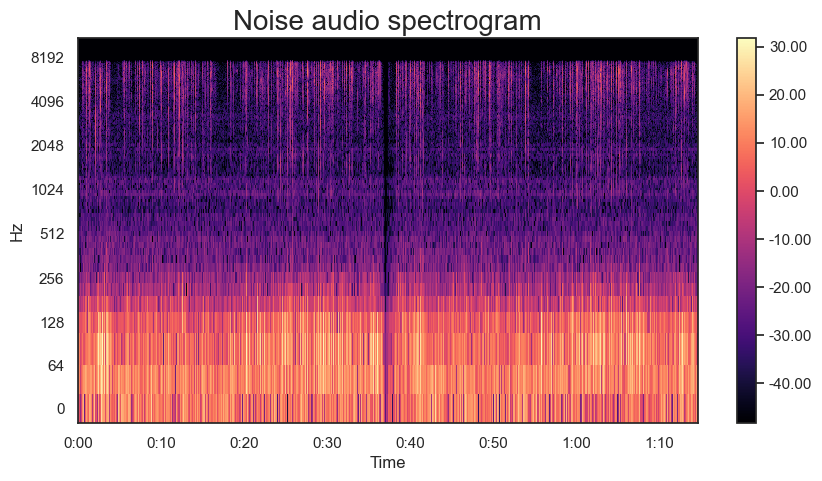

In [275]:
noise_spec= extract(y_noise_trimmed)
plot_spect(noise_spec, 'Noise audio spectrogram')

In [276]:
mixed_audio = y_trimmed + y_noise_trimmed[:len(y_trimmed)] * 0.2

In [252]:
mixed_audio.shape

(85504,)

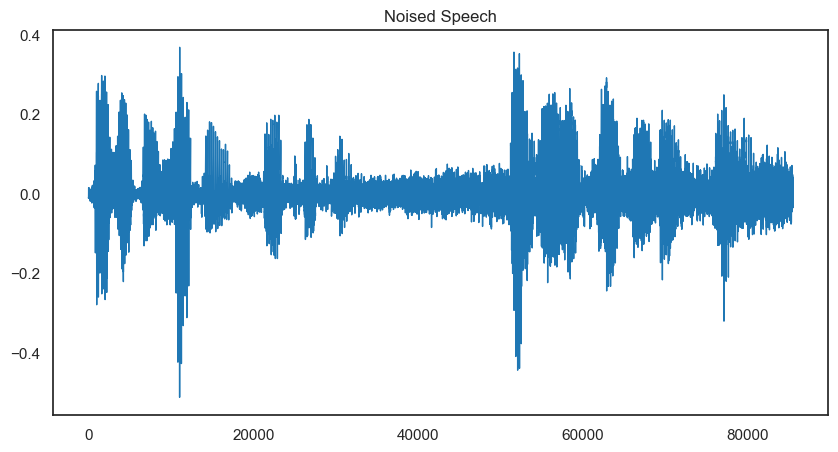

In [253]:
plot_waveform(y=mixed_audio, title='Noised Speech')

In [277]:
sf.write('noised_speech_4.wav', mixed_audio, 22050)
audio = glob('*.wav')
audio

['noised_speech_4.wav']

In [278]:
play_audio(audio[0])

In [279]:
mixed_audio_spec = extract(mixed_audio)

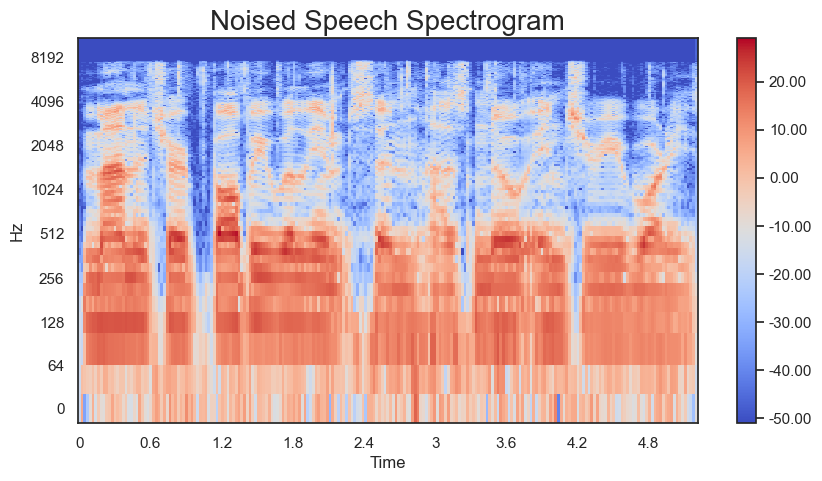

In [280]:
plot_spect(mixed_audio_spec, 'Noised Speech Spectrogram')

In [282]:
mixed_audio_spec.shape

(257, 225)

In [281]:
min_val = np.min(mixed_audio_spec)
max_val = np.max(mixed_audio_spec)

In [283]:
from preprocess import MinMaxNormalizer

min_max_normalizer = MinMaxNormalizer()

normalized_spec = min_max_normalizer.normalize(mixed_audio_spec, min_val, max_val)

In [284]:
def load_numpy(spectrogram, final_shape):
    arr = []
    if spectrogram.shape[1] < final_shape[1]:
    # Pad the spectrogram to match the desired final shape
        pad_width = ((0, 0), (0, final_shape[1] - spectrogram.shape[1]))
        processed_spectrogram = np.pad(spectrogram, pad_width, mode='constant', constant_values=0)
    elif spectrogram.shape[1] > final_shape[1]:
     # Trim the spectrogram to match the desired final shape
        processed_spectrogram = spectrogram[:final_shape[0], :final_shape[1]]
    else:
        processed_spectrogram = spectrogram  # No change needed if the shape is already as desired
    
    # Append the padded spectrogram to the x_train list
    processed_spectrogram = processed_spectrogram[:final_shape[0], :]
    arr.append(processed_spectrogram)
    # Convert the list to a NumPy array if required
    arr = np.array(arr)
    # reshaping to make it suitable for training
    arr = arr.reshape(arr.shape[0], arr.shape[1], arr.shape[2], 1 )
    # print(arr.shape)
    return arr

In [286]:
test_data = load_numpy(normalized_spec, (256, 256))
test_data.shape

(1, 256, 256, 1)

In [287]:
from unet import UNET

model = UNET(
        input_shape=(256, 256, 1),
        conv_filters=(64, 128, 256, 512),
        conv_kernels=(3, 3),
    )

Downsample block shape is:  (None, 256, 256, 64)
Downsample block shape is:  (None, 128, 128, 128)
Downsample block shape is:  (None, 64, 64, 256)
Downsample block shape is:  (None, 32, 32, 512)
upsample block shape is:  (None, 32, 32, 512)
upsample block shape is:  (None, 64, 64, 256)
upsample block shape is:  (None, 128, 128, 128)
upsample block shape is:  (None, 256, 256, 64)


In [288]:
model.load_weights('best_weight.hdf5')

In [289]:
result = model.reconstruct(test_data)

1/1 [==============================] - 1s 803ms/step


In [290]:
result[0].shape

(256, 256, 1)

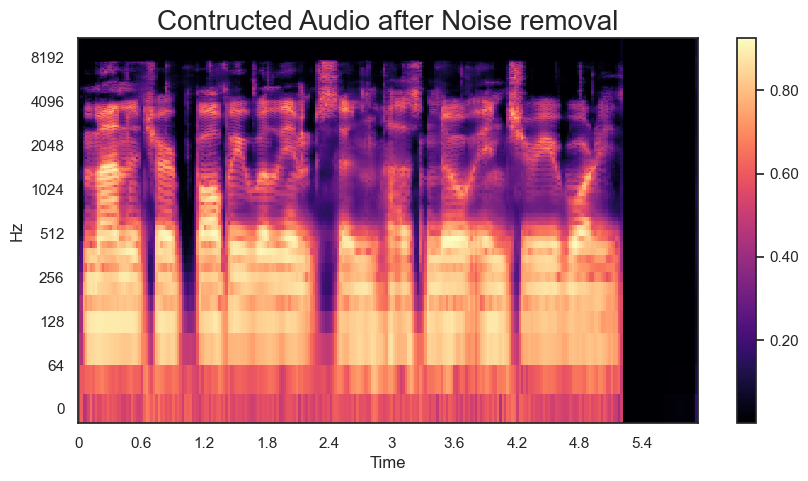

In [291]:
def convert_spectrogram_to_audio( spectrogram, min_val, max_val, min_max_normalizer):
        
        # reshape the log spectrogram
        spectrogram = spectrogram.reshape(spectrogram.shape[0], spectrogram.shape[1],)
        plot_spect(spectrogram, 'Contructed Audio after Noise removal')
            
        # apply denormalisation
        denorm_log_spec = min_max_normalizer.denormalize(
            spectrogram, min_val, max_val)
        # log spectrogram -> spectrogram
        spec = librosa.db_to_amplitude(denorm_log_spec)
        # apply Griffin-Lim
        signal = librosa.istft(spec, hop_length=256)
        return signal

signal = convert_spectrogram_to_audio(result[0], min_val, max_val, min_max_normalizer)

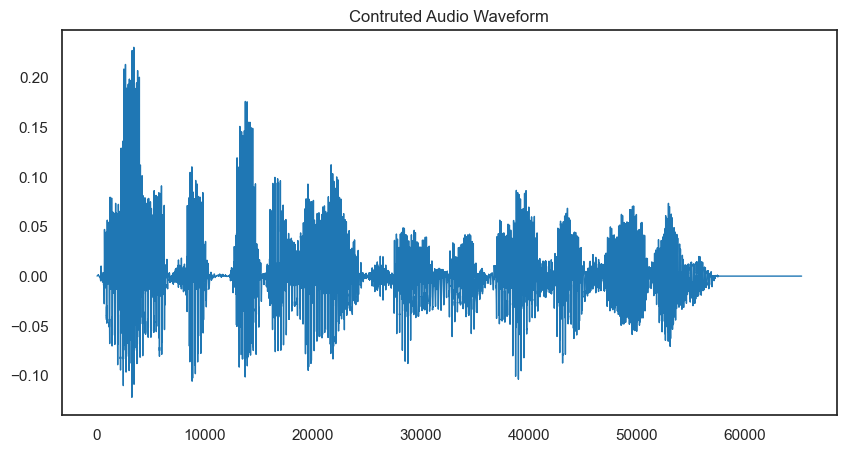

In [292]:
plot_waveform(signal, 'Contruted Audio Waveform')

In [293]:
sf.write('constructed_noised_speech_4.wav', signal, 22050)

In [294]:
constructed_audio = glob('*.wav')
constructed_audio

['constructed_noised_speech_4.wav', 'noised_speech_4.wav']

In [295]:
play_audio(constructed_audio[0])